In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



### ЕС

In [7]:
df_eu  <-  read.csv(file="data_hts/hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [8]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [9]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)
var_char  <-  c(2,1)

In [10]:
75-69

[1] 6

In [11]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
gts_train  <- window(y, start=20, end=67)
gts_test  <- window(y, start=68, end=75)
allts <- aggts(gts_train)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [15]:
library(mvtsplot)

Loading required package: RColorBrewer


In [33]:
length(time(gdp_agg))

[1] 75

In [35]:
dim(gts_train[[1]])

[1]  48 280

In [47]:
gts_train

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 48 
Top level series: 
Time Series:
Start = 20 
End = 67 
Frequency = 1 
 [1] 2564.171 2515.137 2593.341 2594.523 2693.043 2655.689 2724.874 2745.583
 [9] 2852.082 2834.787 2892.483 2914.308 2996.058 2923.510 2963.777 2946.623
[17] 2919.566 2721.873 2766.663 2784.353 2842.605 2784.779 2873.264 2893.451
[25] 2968.661 2921.483 2953.957 2945.649 3011.265 2958.070 3010.722 3033.490
[33] 3075.700 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757
[41] 3236.918 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470

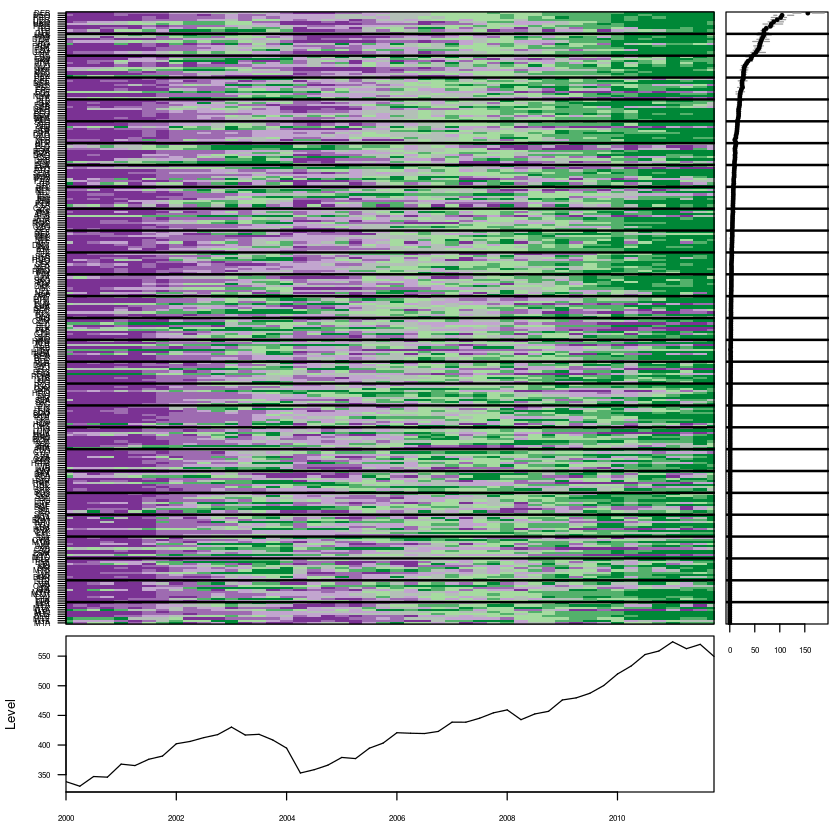

In [52]:
mvtsplot(gts_train[[1]], group = substr(colnames(gts_train[[1]]), 1,2), xtime = time(gdp_agg)[1:48], norm = "internal", level = 7, sort = mean, rowstat = var )

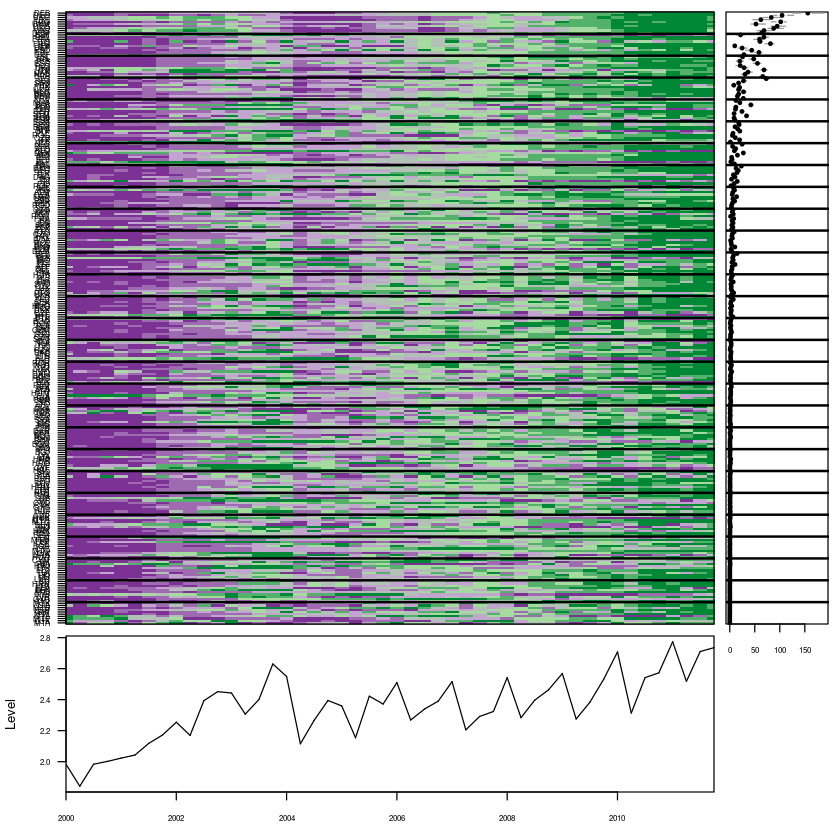

In [50]:
mvtsplot(gts_train[[1]], group = substr(colnames(gts_train[[1]]), 1,2), xtime = time(gdp_agg)[1:48], norm = "internal", level = 7, sort = var )

In [84]:
start_time <- Sys.time()
ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }

end_time <- Sys.time()
end_time - start_time

Time difference of 2.199796 secs

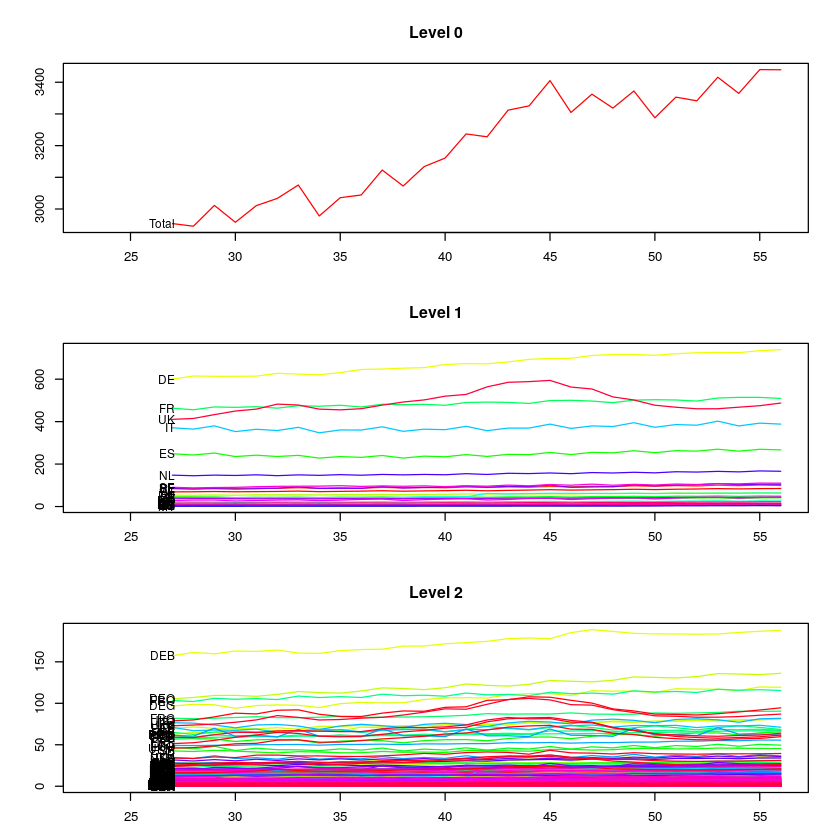

In [85]:
for(i in 1:ncol(allts)){
    allf[,i] <- forecast(ms[[i]], h=var_h)$mean
    }
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7 = y.f[[1]]
colnames(forecasts_7) = colnames(y[[1]])
data_f5 = rbind(gts_train[[1]], forecasts_7)
y_f5 = hts(data_f5, characters = var_char)
plot(y_f5, levels = c(0, 1, 2), include = 30)

In [86]:
gts_forecasts_7  <- window(y_f5,  start=dim(y_f5[[1]])[1]-var_h+1)
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,86.409621,0.8791445,-0.02089313,-0.8095359,-1.027785,1.738947,20.429866,0.04862349,-0.8368866,-0.1620919,⋯,0.7600803,11.08207,5.732651,7.835159,3.271404,-2.102235,9.816359,7.620617,2.883496,1.953432
RMSE,90.709593,1.0108940,0.29689804,0.9049042,1.127968,2.074521,22.533945,0.87923292,0.9228144,0.6090558,⋯,0.8038689,11.48393,5.971085,8.133038,3.448998,2.340960,10.263709,8.140523,4.012751,2.120936
MAE,86.409621,0.8791445,0.23820825,0.8095359,1.027785,1.738947,20.429866,0.69662838,0.8368866,0.5100542,⋯,0.7600803,11.08207,5.732651,7.835159,3.271404,2.102235,9.816359,7.620617,3.463137,1.953432
MAPE,2.484834,1.0423082,0.24215006,7.1673774,23.659767,3.823036,2.714768,1.09898507,15.8216791,1.2816135,⋯,22.1263765,14.98898,17.917554,8.405007,9.569124,5.741726,13.876817,11.516694,3.753251,8.762493
MPE,2.484834,1.0423082,-0.01896504,-7.1673774,-23.659767,3.823036,2.714768,0.08033434,-15.8216791,-0.4477034,⋯,22.1263765,14.98898,17.917554,8.405007,9.569124,-5.741726,13.876817,11.516694,3.124505,8.762493


In [87]:
var_acc_metrics  <-  c(1,2,5)

In [88]:
accuracy.gts(gts_forecasts_7, gts_test)[var_acc_metrics,1]

ME      RMSE       MPE 
86.409621 90.709593  2.484834

In [1]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
            
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    for(j in 1:ncol(allts)){
        allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    }
    
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
            
    
    l[[k]]  <- allf

    ac[[i+1]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

            
            
    progress(i, progress.bar = TRUE)
            
    }

ERROR: Error in eval(expr, envir, enclos): object 'var_iter' not found


In [90]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [91]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [92]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [93]:
df_acc

ME,RMSE,MAPE,Iteration
-24.27503,39.11367,1.0288193,1
-17.91662,30.36804,0.8362184,5
57.98127,74.87051,1.7517469,9
61.35760,66.56714,1.8366534,13
-62.74753,70.72910,1.9165411,17
86.40962,90.70959,2.4848337,20


In [94]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3382.563 3436.319 3425.729 3476.709 3442.388 3484.096 3474.481 3525.213

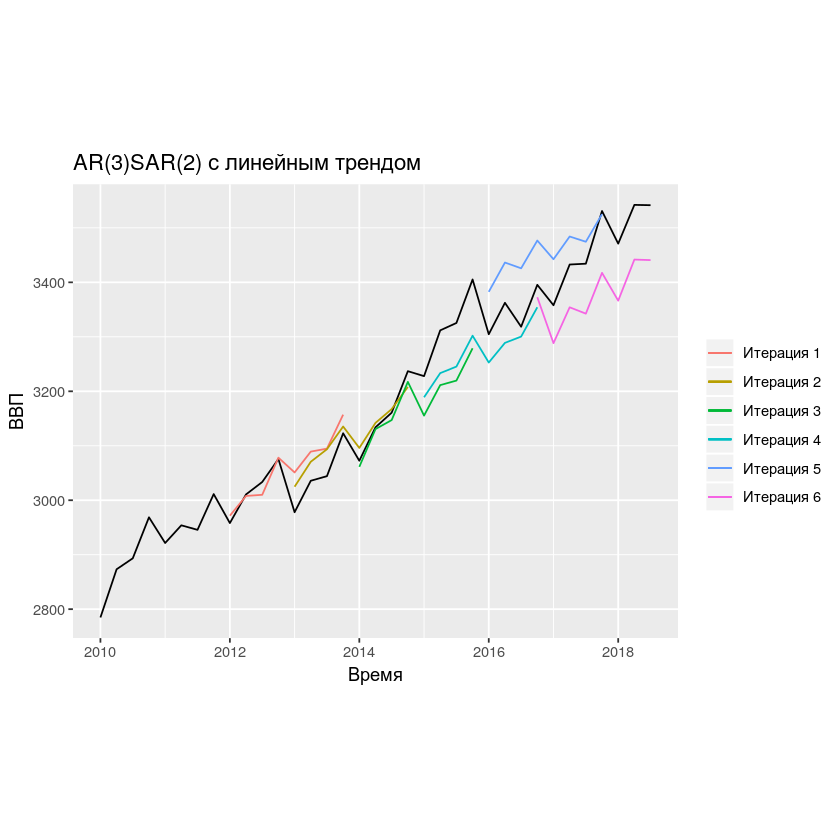

In [95]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [96]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
16.801551 62.059674  1.642469 10.833333

In [97]:
df_mean_acc <- readRDS("df_mean_acc.rds")
rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [98]:
df_mean_acc[2,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.83956,242.0385,8410.941
3 level,62.05967,NA,NA
2 level (state),NA,NA,NA
2 level (type),NA,NA,NA
2 level (clusetered),NA,NA,NA


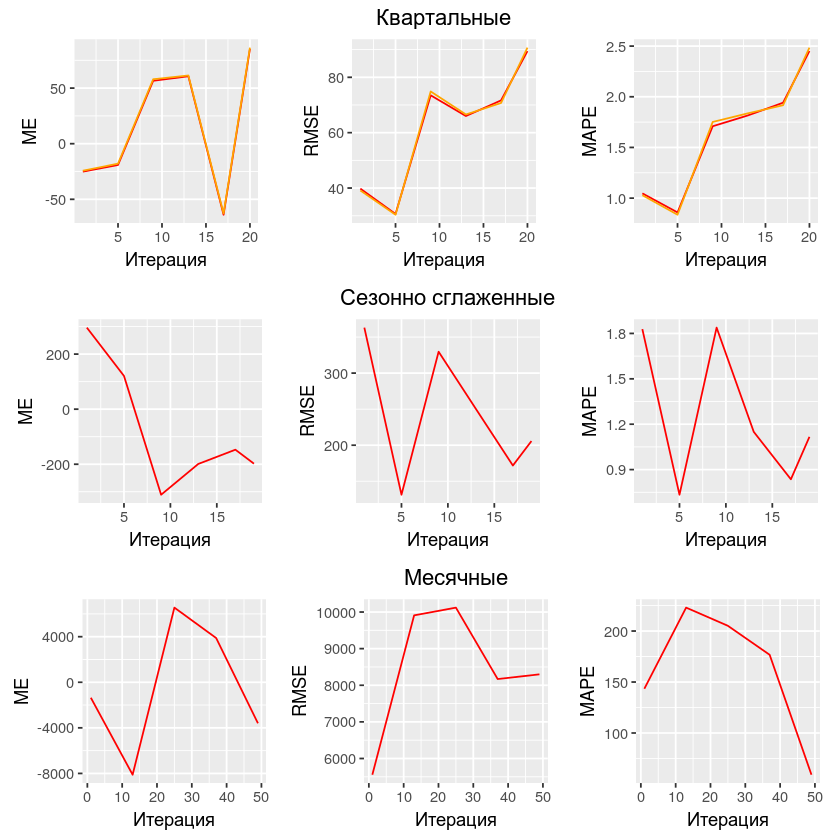

In [99]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [100]:
df_eu  <-  read.csv(file="hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [101]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [102]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)
var_char  <-  c(2,1)

In [103]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [104]:
df_eu  <-  as.data.table(allts[,2:29])
data  <-  df_eu
y  <-  hts(data)

Since argument characters are not specified, the default labelling system is used.


In [105]:
gts_train  <- window(y, start=20, end=67)
gts_test  <- window(y, start=68, end=75)
allts <- aggts(gts_train)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [106]:
start_time <- Sys.time()
ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }

end_time <- Sys.time()
end_time - start_time

Time difference of 0.3883951 secs

Since argument characters are not specified, the default labelling system is used.


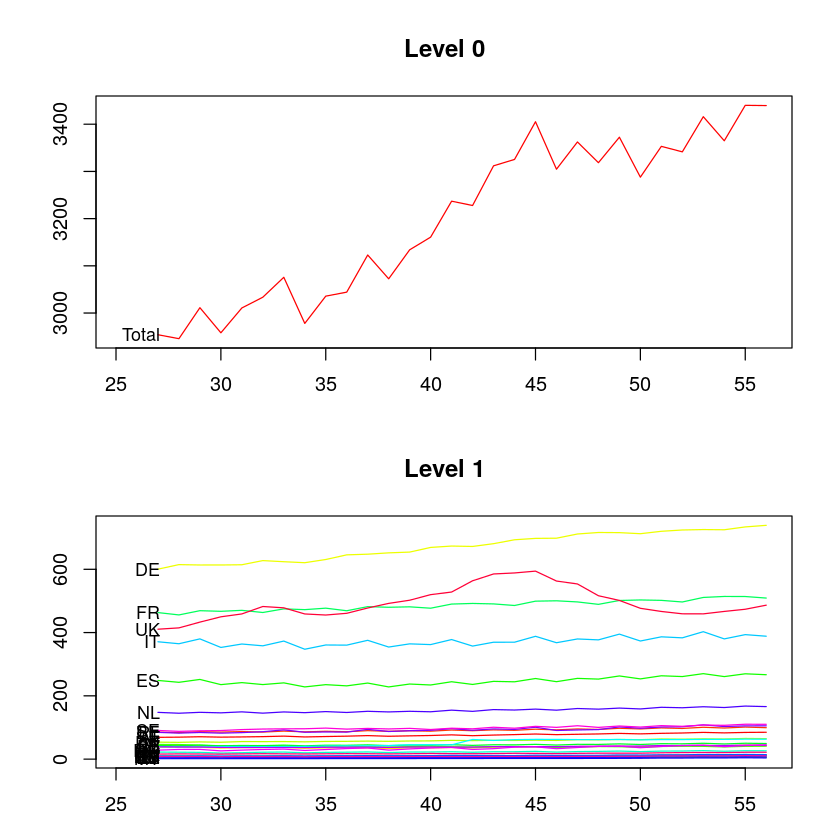

In [107]:
for(i in 1:ncol(allts)){
    allf[,i] <- forecast(ms[[i]], h=var_h)$mean
    }
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7 = y.f[[1]]
colnames(forecasts_7) = colnames(y[[1]])
data_f5 = rbind(gts_train[[1]], forecasts_7)
y_f5 = hts(data_f5)
plot(y_f5, levels = c(0, 1), include = 30)

In [108]:
gts_forecasts_7  <- window(y_f5,  start=dim(y_f5[[1]])[1]-var_h+1)
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,LV,MT,NL,PL,PT,RO,SE,SI,SK,UK
ME,86.347993,0.8374655,-0.08685711,-0.8653775,-1.079258,1.695513,20.58283,0.01720453,-0.8803205,-0.2425889,⋯,-0.7372783,-1.024612,3.705335,0.6760916,-0.3448047,1.560211,-2.538328,-0.6367885,-1.039186,49.845001
RMSE,90.642760,0.9705407,0.31724758,0.9592835,1.181387,2.034759,22.69226,0.88658844,0.9686761,0.6334048,⋯,0.8343901,1.121449,4.274485,1.7829810,0.4077502,2.053962,4.596864,0.6987548,1.135572,52.193147
MAE,86.347993,0.8374655,0.24661931,0.8653775,1.079258,1.705733,20.58283,0.69528306,0.8803205,0.5427435,⋯,0.7372783,1.024612,3.705335,1.5093616,0.3548295,1.580896,3.157514,0.6367885,1.039186,49.845001
MAPE,2.483072,0.9926772,0.25067802,7.6551130,24.851222,3.750438,2.73514,1.09684679,16.6473105,1.3689920,⋯,12.0691277,39.573889,2.184341,1.4350602,0.8337665,3.463945,3.094640,6.6255981,5.322985,9.499988
MPE,2.483072,0.9926772,-0.08570040,-7.6551130,-24.851222,3.724424,2.73514,0.03099966,-16.6473105,-0.6504855,⋯,-12.0691277,-39.573889,2.184341,0.5917906,-0.8093789,3.411425,-2.496390,-6.6255981,-5.322985,9.499988


In [109]:
var_acc_metrics  <-  c(1,2,5)

In [110]:
accuracy.gts(gts_forecasts_7, gts_test)[var_acc_metrics,1]

ME      RMSE       MPE 
86.347993 90.642760  2.483072

In [111]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
            
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    for(j in 1:ncol(allts)){
        allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    }
    
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
            
    
    l[[k]]  <- allf

    ac[[i+1]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

            
            
    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2970.909 3007.407 3009.277 3077.338 3049.475 3088.566 3093.940 3156.042
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3024.563 3070.479 3092.908 3134.456 3094.586 3140.580 3165.046 3206.091
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3061.276 3130.096 3145.920 3215.651 3153.958 3209.831 3217.891 3276.914
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3188.759 3233.260 3244.961 3301.496 3251.868 3288.110 3299.273 3352.985
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3381.723 3435.385 3425.093 3476.249 3440.924 3482.567 3473.321 3524.164
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3372.450 3287.822 3353.086 3341.420 3415.920 3364.889 3439.987 3439.487
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [112]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [113]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [114]:
df_acc

ME,RMSE,MAPE,Iteration
-24.26646,39.11236,1.0288841,1
-17.97544,30.37880,0.8372938,5
57.84586,74.74118,1.7476030,9
61.30557,66.52105,1.8350951,13
-62.85344,70.82337,1.9190550,17
86.34799,90.64276,2.4830716,20


In [115]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3382.563 3436.319 3425.729 3476.709 3442.388 3484.096 3474.481 3525.213

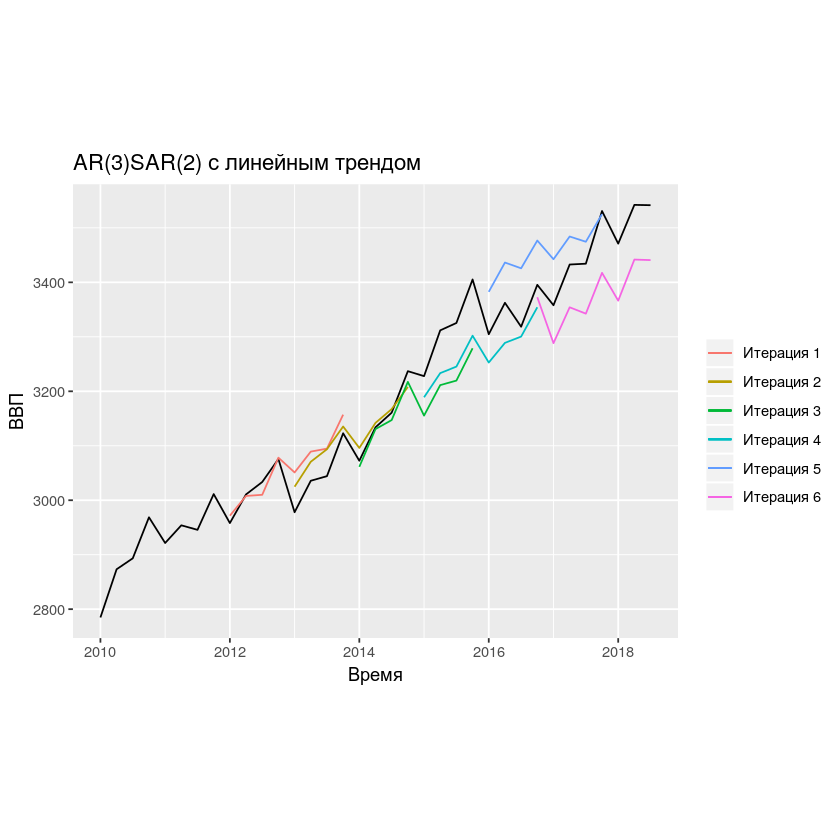

In [116]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [117]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
16.734015 62.036587  1.641834 10.833333

In [118]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [119]:
df_mean_acc[3,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.83956,242.0385,8410.941
3 level,62.05967,NA,NA
2 level (state),62.03659,NA,NA
2 level (type),NA,NA,NA
2 level (clusetered),NA,NA,NA


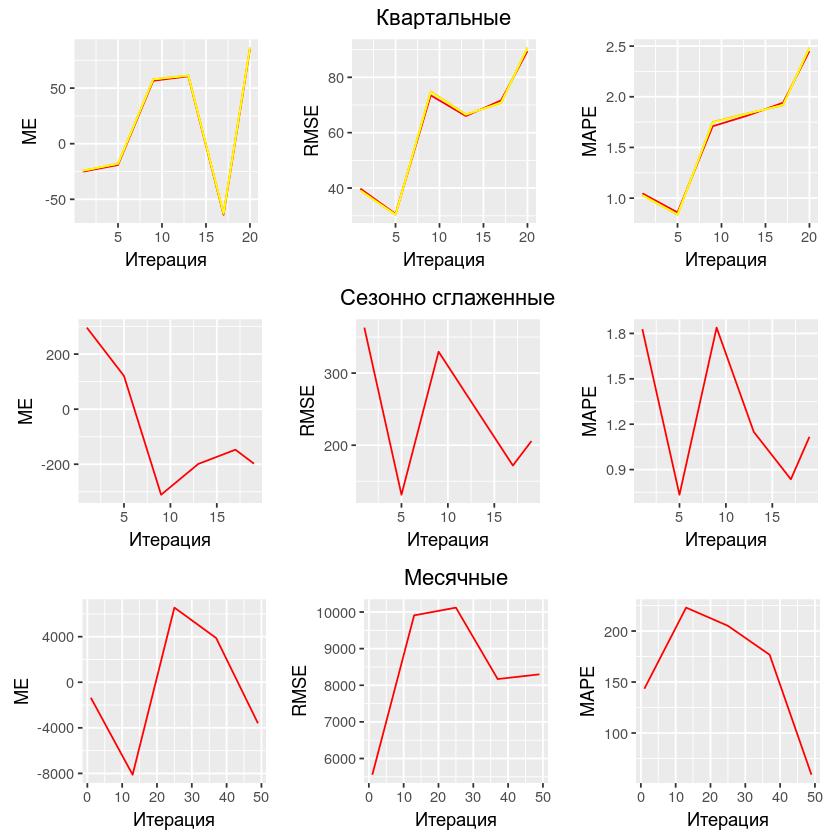

In [120]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [121]:
df_eu  <-  read.csv(file="hts_eu_a10_type.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [122]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [123]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)
var_char  <-  c(2,1)

In [124]:
75-69

[1] 6

In [125]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
gts_train  <- window(y, start=20, end=67)
gts_test  <- window(y, start=68, end=75)
allts <- aggts(gts_train)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [126]:
start_time <- Sys.time()
ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }

end_time <- Sys.time()
end_time - start_time

Time difference of 0.2034047 secs

Since argument characters are not specified, the default labelling system is used.


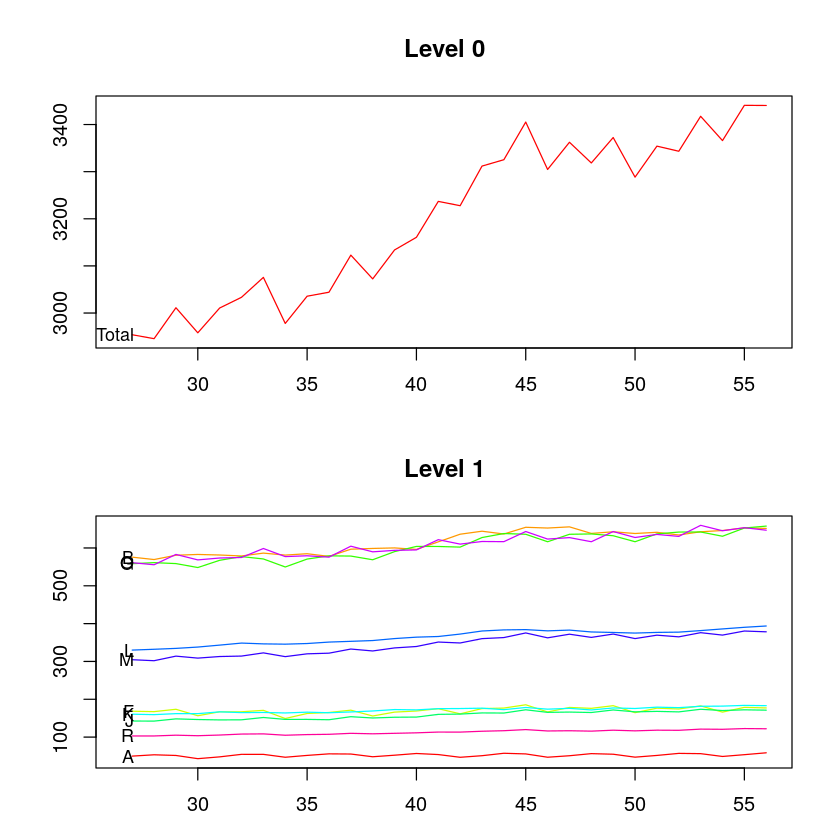

In [127]:
for(i in 1:ncol(allts)){
    allf[,i] <- forecast(ms[[i]], h=var_h)$mean
    }
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7 = y.f[[1]]
colnames(forecasts_7) = colnames(y[[1]])
data_f5 = rbind(gts_train[[1]], forecasts_7)
y_f5 = hts(data_f5)
plot(y_f5, levels = c(0, 1), include = 30)

In [128]:
gts_forecasts_7  <- window(y_f5,  start=dim(y_f5[[1]])[1]-var_h+1)
accuracy.gts(gts_forecasts_7, gts_test)

,Total,A,B,F,G,J,K,L,M,O,R
ME,85.368375,3.057198,36.192661,12.382230,21.419738,4.370992,-11.076019,5.314452,14.540669,-1.3306626,0.4971171
RMSE,89.588019,3.334907,37.461901,14.088549,22.560089,4.953234,11.478899,6.012685,15.779091,1.5505205,1.2083579
MAE,85.368375,3.057198,36.192661,12.382230,21.419738,4.370992,11.076019,5.314452,14.540669,1.3306626,1.0067808
MAPE,2.454883,5.346731,5.301388,6.489025,3.220787,2.480862,6.564895,1.372444,3.735472,0.2074044,0.8369165
MPE,2.454883,5.346731,5.301388,6.489025,3.220787,2.480862,-6.564895,1.372444,3.735472,-0.2074044,0.4162195


In [129]:
var_acc_metrics  <-  c(1,2,5)

In [130]:
accuracy.gts(gts_forecasts_7, gts_test)[var_acc_metrics,1]

ME      RMSE       MPE 
85.368375 89.588019  2.454883

In [131]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
            
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    for(j in 1:ncol(allts)){
        allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    }
    
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
            
    
    l[[k]]  <- allf

    ac[[i+1]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

            
            
    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2970.923 3008.101 3010.622 3078.569 3050.461 3089.660 3095.661 3157.963
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3025.012 3070.755 3093.409 3135.592 3096.069 3142.122 3167.098 3208.251
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3061.324 3130.141 3146.752 3216.223 3153.983 3209.751 3218.500 3277.581
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3188.377 3232.929 3245.069 3301.817 3252.100 3288.713 3300.756 3354.436
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3381.477 3434.884 3424.874 3475.762 3440.406 3482.199 3473.725 3524.398
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3372.433 3288.393 3354.166 3343.320 3417.482 3365.917 3440.743 3440.443
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [132]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [133]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [134]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [135]:
df_acc

ME,RMSE,MAPE,Iteration
-25.39222,39.90694,1.048923,1
-19.17524,30.62842,0.858874,5
57.50614,74.45790,1.737197,9
60.87026,66.24728,1.822202,13
-62.64076,70.53197,1.911019,17
85.36838,89.58802,2.454883,20


In [136]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3382.563 3436.319 3425.729 3476.709 3442.388 3484.096 3474.481 3525.213

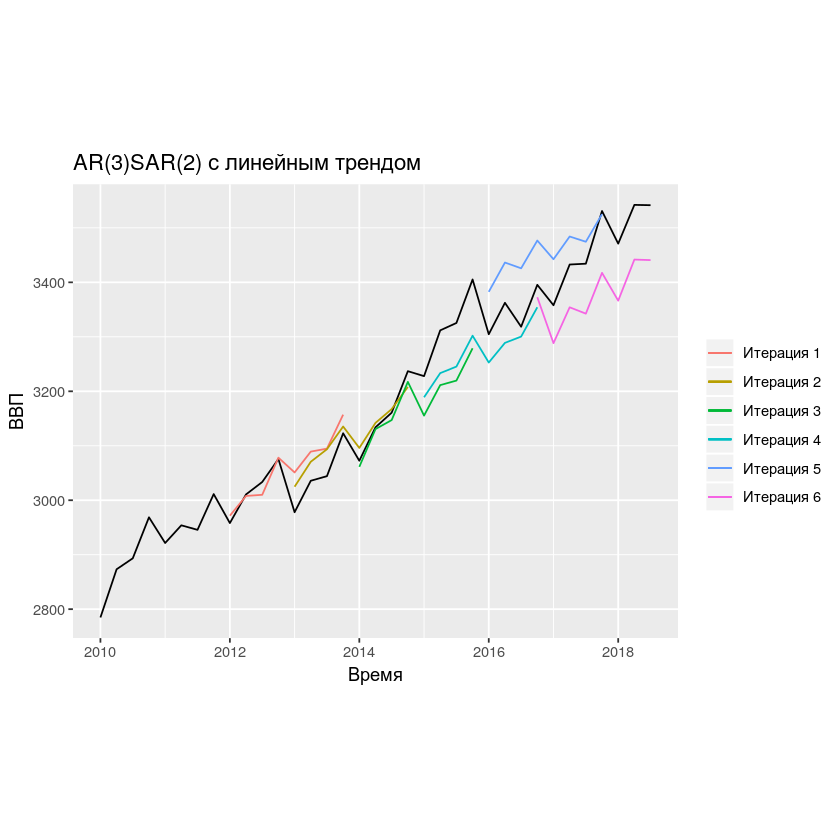

In [137]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [138]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
 16.08943  61.89342   1.63885  10.83333

In [139]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [140]:
df_mean_acc[4,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.83956,242.0385,8410.941
3 level,62.05967,NA,NA
2 level (state),62.03659,NA,NA
2 level (type),61.89342,NA,NA
2 level (clusetered),NA,NA,NA


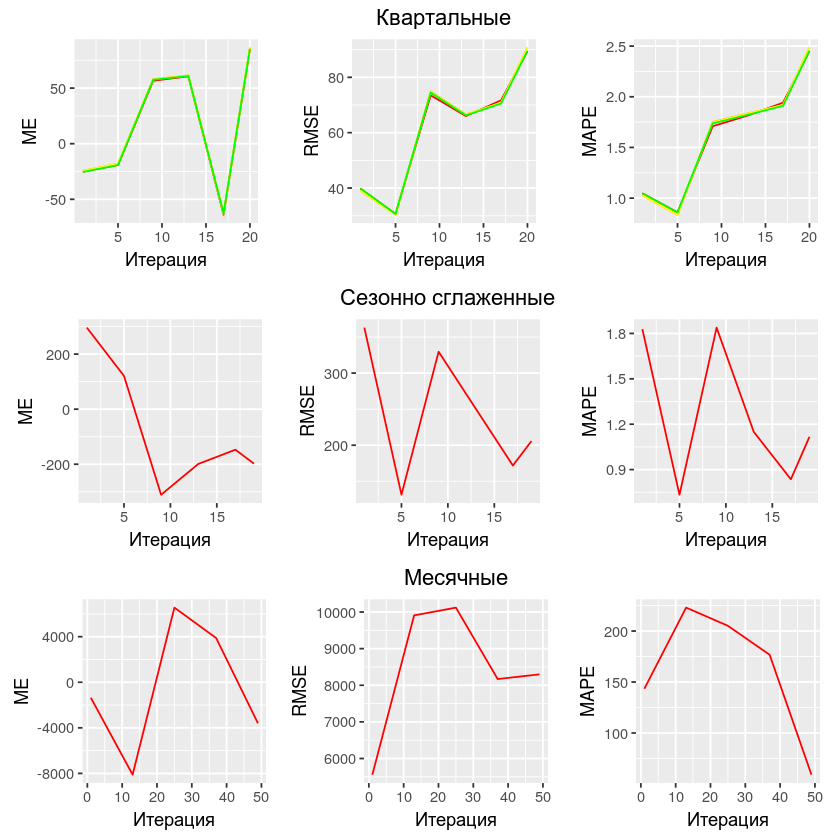

In [141]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [142]:
df_eu  <-  read.csv(file="hts_eu_a10_clust.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [143]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [144]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)
var_char  <-  c(2,1)

In [145]:
75-69

[1] 6

In [146]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
gts_train  <- window(y, start=20, end=67)
gts_test  <- window(y, start=68, end=75)
allts <- aggts(gts_train)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [147]:
start_time <- Sys.time()
ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }

end_time <- Sys.time()
end_time - start_time

Time difference of 0.1881688 secs

Since argument characters are not specified, the default labelling system is used.


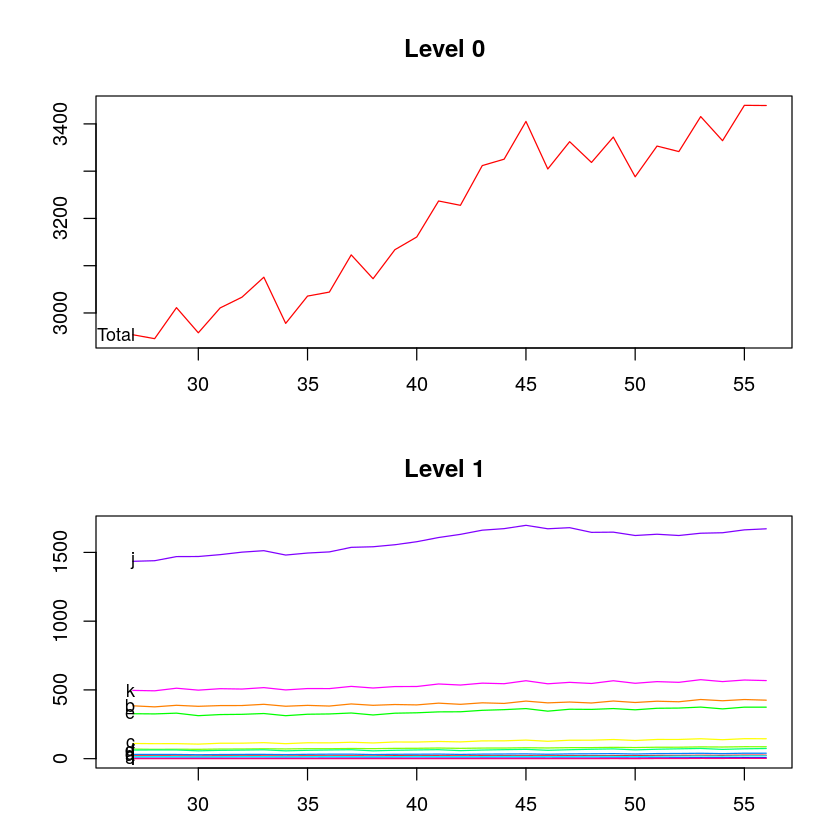

In [148]:
for(i in 1:ncol(allts)){
    allf[,i] <- forecast(ms[[i]], h=var_h)$mean
    }
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7 = y.f[[1]]
colnames(forecasts_7) = colnames(y[[1]])
data_f5 = rbind(gts_train[[1]], forecasts_7)
y_f5 = hts(data_f5)
plot(y_f5, levels = c(0, 1), include = 30)

In [149]:
gts_forecasts_7  <- window(y_f5,  start=dim(y_f5[[1]])[1]-var_h+1)
accuracy.gts(gts_forecasts_7, gts_test)

,Total,a,b,c,d,e,f,g,h,i,j,k,l
ME,86.582742,-0.5294969,3.6547573,4.866185,1.218052,10.58630,0.9728592,-0.7858718,-0.06470232,-1.186495,63.091633,6.096230,-1.336707
RMSE,90.901657,0.7208370,4.1447412,5.365394,1.497118,11.50824,1.5149764,0.9534111,0.50808788,1.363760,65.800348,8.182470,1.529769
MAE,86.582742,0.6104018,3.6547573,4.866185,1.247155,10.58630,1.0301999,0.7858718,0.44520265,1.186495,63.091633,7.441428,1.336707
MAPE,2.489701,2.6024058,0.8619742,3.306236,1.446528,2.77125,1.3755420,4.4309171,1.17221089,25.421993,3.686191,1.298933,2103.391940
MPE,2.489701,-2.2345696,0.8619742,3.306236,1.411195,2.77125,1.2934946,-4.4309171,-0.18589653,-25.421993,3.686191,1.059244,-2103.391940


In [150]:
var_acc_metrics  <-  c(1,2,5)

In [151]:
accuracy.gts(gts_forecasts_7, gts_test)[var_acc_metrics,1]

ME      RMSE       MPE 
86.582742 90.901657  2.489701

In [152]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
            
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    for(j in 1:ncol(allts)){
        allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    }
    
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
            
    
    l[[k]]  <- allf

    ac[[i+1]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

            
            
    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2971.564 3008.303 3010.721 3078.766 3051.501 3090.196 3095.768 3157.574
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3025.536 3071.334 3094.009 3135.401 3096.468 3142.392 3167.177 3207.625
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3061.608 3130.511 3146.887 3216.386 3154.984 3210.575 3218.860 3277.566
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3189.110 3233.527 3245.261 3301.462 3252.183 3288.488 3299.667 3352.824
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3381.890 3435.464 3424.883 3475.465 3440.647 3482.118 3472.673 3522.931
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3372.162 3288.144 3353.125 3341.491 3415.537 3364.503 3439.307 3438.913
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [153]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [154]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [155]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [156]:
df_acc

ME,RMSE,MAPE,Iteration
-25.69634,40.22887,1.0566376,1
-19.37969,31.04577,0.8705958,5
57.11604,74.11595,1.7251227,9
61.07946,66.33240,1.8282411,13
-62.43409,70.59681,1.9156446,17
86.58274,90.90166,2.4897006,20


In [157]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3382.563 3436.319 3425.729 3476.709 3442.388 3484.096 3474.481 3525.213

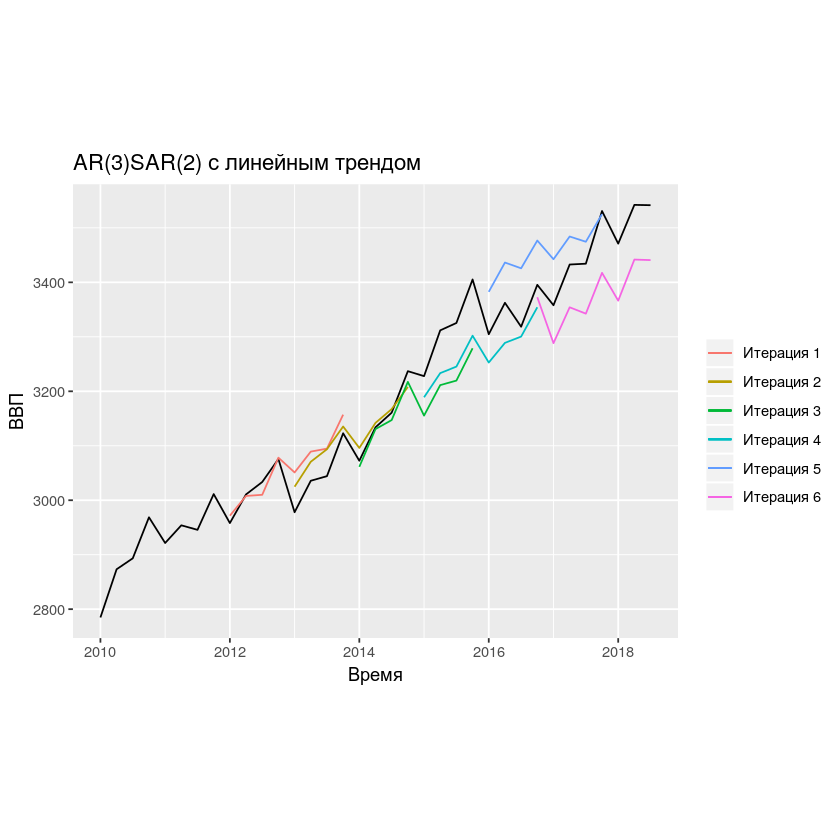

In [158]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [159]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
16.211354 62.203575  1.647657 10.833333

In [160]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [161]:
df_mean_acc[5,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.83956,242.0385,8410.941
3 level,62.05967,NA,NA
2 level (state),62.03659,NA,NA
2 level (type),61.89342,NA,NA
2 level (clusetered),62.20357,NA,NA


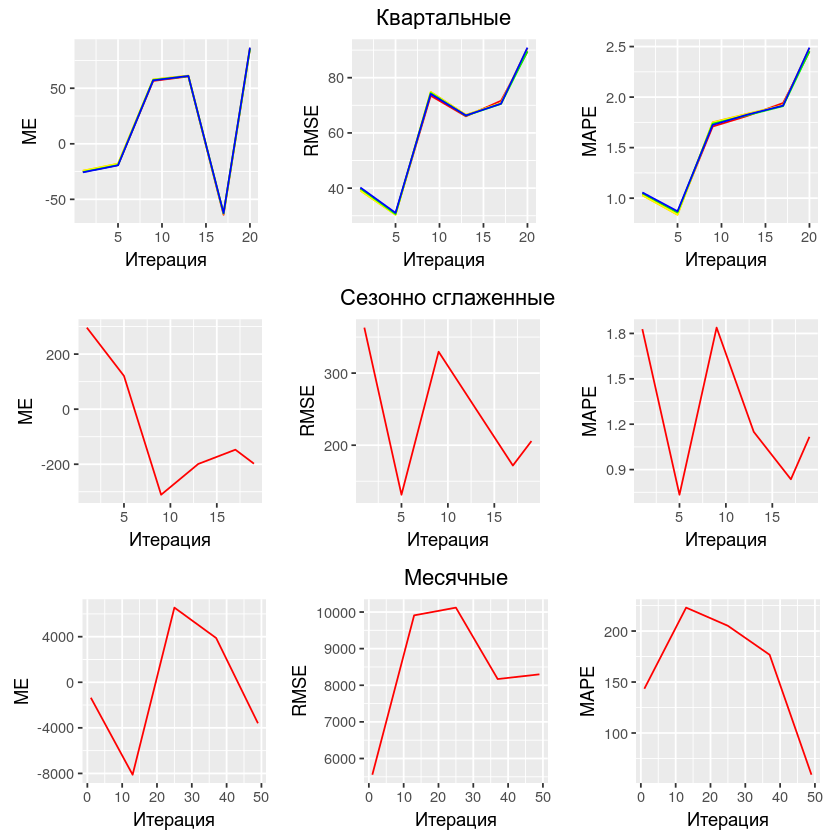

In [162]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [163]:
saveRDS(df_mean_acc, "df_mean_acc.rds")

In [164]:
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.83956,242.0385,8410.941
3 level,62.05967,NA,NA
2 level (state),62.03659,NA,NA
2 level (type),61.89342,NA,NA
2 level (clusetered),62.20357,NA,NA


In [165]:


saveRDS(plots_test_all, "plots_test_not_all.rds")